### Erddap Quicklooks of ThingSpeak archived data

__pyversion__==3.7   
__author__==S.Bell

__Notes:__ 

```
Full Scale details... temp better at 25degC

DHT11 - 0-50C +/- 2degC, 0.1
      - 20-90% +/- 5%, 1
      
BMP180 - temp is +/- 2degc
       - baro is +/- 1hpa (and a 1hpa res for relative?)
```

In [16]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2019-10-07 07:16:35.219225


In [17]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in ['channel_843357_thingspeak']]
print(variables)

[['BaroTemp', 'SLP', 'RH_Percent', 'Temp', 'time']]


In [18]:

d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='channel_843357_thingspeak'

d.variables =  [d.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in [d.dataset_id]][0]

d.constraints = {
    'time>=': datetime.datetime.today()-datetime.timedelta(days=30),
    'time<=': datetime.datetime.utcnow()
}

d.get_download_url()

'http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/channel_843357_thingspeak.csv?BaroTemp,SLP,RH_Percent,Temp,time&time>=1567840595.514048&time<=1570457795.514075'

In [19]:
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.sort_index(inplace=True)
df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

df.tail()

,BaroTemp,SLP,RH_Percent,Temp
time (UTC),,,,
2019-10-06 21:54:41+00:00,26.0,1021.0,36.0,25.9
2019-10-06 21:55:48+00:00,26.0,1020.0,36.0,25.9
2019-10-06 21:56:55+00:00,26.1,1020.0,36.0,25.9
2019-10-06 21:58:02+00:00,26.1,1020.0,37.0,26.0
2019-10-06 21:59:09+00:00,26.1,1020.0,37.0,26.0


In [20]:
datetime.datetime.utcnow()

datetime.datetime(2019, 10, 7, 14, 16, 43, 597743)

In [21]:
#get some nearby data
import requests
import xml.etree.ElementTree as ET

user_agent_url = 'https://w1.weather.gov/xml/current_obs/KPAE.xml'
kpae = {} #Payne Field
try:
    xml_data = requests.get(user_agent_url).content
    res = requests.get("http://w1.weather.gov/xml/current_obs/KPAE.xml")
    xml_tree = ET.fromstring(res.text)
    kpae['temp_c'] = xml_tree.find('temp_c').text
    kpae['relative_humidity'] = xml_tree.find('relative_humidity').text
    kpae['pressure_mb'] = xml_tree.find('pressure_mb').text
    kpae['observation_time_rfc822'] = xml_tree.find('observation_time_rfc822').text
    kpae['datetime'] = datetime.datetime.strptime(kpae['observation_time_rfc822'],'%a, %d %b %Y %H:%M:%S %z')
except:
    pass

kpae

{'temp_c': '11.7',
 'relative_humidity': '74',
 'pressure_mb': '1017.3',
 'observation_time_rfc822': 'Mon, 07 Oct 2019 06:53:00 -0700',
 'datetime': datetime.datetime(2019, 10, 7, 6, 53, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=61200)))}

In [22]:
kpae['observation_time_rfc822'] = xml_tree.find('observation_time_rfc822').text

In [23]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean
### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

Average difference between two sensors for all time: -0.5458498958924731
Average difference between two sensors for last two weeks: -0.5944022726214405


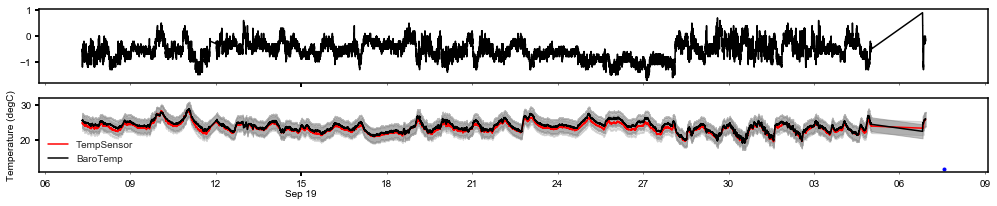

In [24]:
fig, (ax2, ax1) = plt.subplots(2,1,sharex='col',figsize=(17,3))
ax1.plot(df.index,df['Temp'],'r',df.index,df['BaroTemp'],'k')
ax1.fill_between(df.index,df['Temp']-2,df['Temp']+2,color='grey',alpha=.25)
ax1.fill_between(df.index,df['BaroTemp']-2,df['BaroTemp']+2,color='grey',alpha=.5)
ax2.plot(df.index,df['Temp']-df['BaroTemp'],'k')
plt.ylabel('Temperature (degC)')


try:
    pass
    ax1.plot(kpae['datetime'],np.float(kpae['temp_c']),'ob',markersize=3)
except:
    pass

plt.legend(['TempSensor','BaroTemp'])
#ax1.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax1.xaxis.set_tick_params(which='major', pad=3)
ax1.xaxis.set_tick_params(which='minor', pad=5)

print(f"Average difference between two sensors for all time: {(df['Temp']-df['BaroTemp']).mean()}")
two_weeks_delta = (df['Temp'][df.last_valid_index()-pd.DateOffset(14, 'D'):] - 
                  df['BaroTemp'][df.last_valid_index()-pd.DateOffset(14, 'D'):]).mean()
print(f"Average difference between two sensors for last two weeks: {two_weeks_delta}")

In [ ]:
fig, (ax2, ax1) = plt.subplots(2,1,sharex='col',figsize=(17,3))
ax1.plot(df.index,df['RH_Percent'],'g')
ax1.fill_between(df.index,df['RH_Percent']-5,df['RH_Percent']+5,color='grey',alpha=.25)
ax2.plot(df.index,df['Temp'],'r')
ax2.fill_between(df.index,df['Temp']-2,df['Temp']+2,color='grey',alpha=.25)
plt.ylabel('Temperature (degC)')

try:
    pass
    ax1.plot(kpae['datetime'],np.float(kpae['relative_humidity']),'ob',markersize=3)
    ax2.plot(kpae['datetime'],np.float(kpae['temp_c']),'ob',markersize=3)
except:
    pass

xfmt = mdates.DateFormatter('%d-%b')
ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax1.xaxis.set_tick_params(which='major', pad=3)
ax1.xaxis.set_tick_params(which='minor', pad=5)

In [ ]:
fig, ax1 = plt.subplots(1,1,sharex='col',figsize=(17,1.5))
ax1.plot(df.index,df['SLP'],'k')
ax1.fill_between(df.index,df['SLP']-1,df['SLP']+1,color='grey',alpha=.25)
plt.ylabel('SLP (mbar)')

try:
    pass
    ax1.plot(kpae['datetime'],np.float(kpae['pressure_mb']),'ob',markersize=3)
except:
    pass

xfmt = mdates.DateFormatter('%d-%b')
ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax1.xaxis.set_tick_params(which='major', pad=3)
ax1.xaxis.set_tick_params(which='minor', pad=5)

In [ ]:
### build a table of daily max/min
daily_summary = pd.DataFrame(columns=df.columns)

for column in daily_summary:
    daily_summary[column+' (min)'] = df[column].resample('D').min()
    daily_summary[column+' (max)'] = df[column].resample('D').max()
    daily_summary[column+' (median)'] = df[column].resample('D').median()
    daily_summary[column] = df[column].resample('D').mean()
    


In [ ]:
def highlight_max(s):
    '''
    highlight the maximum in a Series red.
    '''
    is_max = s == s.max()
    return ['color: red' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['color: blue' if v else '' for v in is_min]



In [ ]:
daily_summary.style.apply(highlight_max).apply(highlight_min).format("{:.2f}")

In [ ]:
(daily_summary - daily_summary.mean()).style.bar(align='mid', color=['#d65f5f', '#5fba7d'])
